# Exercise 2

## Imports

In [1]:
import os.path
import random
import pyspark.sql.functions as F
from pyspark.sql import SparkSession, Row, DataFrame
from pyspark.sql.types import StringType, ArrayType, IntegerType, StructType, StructField, DecimalType
from itertools import combinations, chain
from functools import partial
from typing import Iterable, Any, List, Callable

## Parameters

The values for parameters $b$ and $r$ chosen, according to the requirements, were:
- $b = 13$
- $r = 11$

The values were hand-picked by visually analyzing the plot for the probability of two documents sharing a bucket depending on their similarity, as $b$ and $r$ changed.

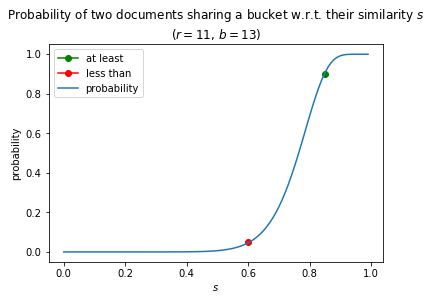

In [2]:
N = 100

r = 11
b = 13

point_below = (0.85, 0.9)
point_above = (0.6, 0.05)

prob = lambda s, r, b: 1 - (1 - s**r)**b

try:
    import matplotlib.pyplot as plt

    ss = [i/N for i in range(N)]

    plt.plot(*point_below, color='g', marker='o')
    plt.plot(*point_above, color='r', marker='o')
    plt.plot(ss, [prob(s, r, b) for s in ss])

    plt.title(f'Probability of two documents sharing a bucket w.r.t. their similarity $s$\n($r={r}$, $b={b}$)')
    plt.legend(['at least', 'less than', 'probability'])
    plt.xlabel('$s$')
    plt.ylabel('probability')

    plt.show()

except ImportError:
    print('Could not plot, since the \'matplotlib\' module is not present.')

assert prob(point_below[0], r, b) >= point_below[1], 'Pairs with a similarity of 85%% should have at least 90%% probability of sharing a bucket!'
assert prob(point_above[0], r, b) <  point_above[1], 'Pairs with a similarity of 60%% should have less than 5%% probability of sharing a bucket!'

In [2]:
# Shingle size
k = 9

# Number of bands
b = 13

# Number of rows per band
r = 11

# Min-hash: number of hash functions
num_functions = b*r

# Seed for the random number generator
seed = 123

# Similarity threshold
similarity_threshold = 0.85

# Sample of the dataset to use
sample_fraction = 0.01

# Number of explicit partitions
num_partitions = 8

In [3]:
random.seed(seed)

## Spark Initialization

In [4]:
spark = SparkSession.builder \
    .appName('LSH') \
    .config('spark.master', 'local[*]') \
    .getOrCreate()

23/03/22 14:24:47 WARN Utils: Your hostname, martinho-SATELLITE-L50-B resolves to a loopback address: 127.0.1.1; using 192.168.47.76 instead (on interface wlx200db038271f)
23/03/22 14:24:47 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/03/22 14:24:49 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Prepare the Data

In [5]:
# TODO: Configure partitions for speedup?
df = spark.read \
    .json('./data/covid_news_small.json.bz2') \
    .repartition(num_partitions)

## Pipeline

### Generate shingles

In [6]:
# TODO: ignore punctuation? use different shingling strategy? (see 'Further fun' slide, which is the last, of 3b)
@F.udf(returnType=ArrayType(IntegerType(), False))
def generate_shingles(text: str):
    shingles = (text[idx:idx+k] for idx in range(len(text) - k + 1))
    # Get last 32 bits in order to have 4-byte integers (Python allows arbitrarily large integers)
    to_integer = lambda s: hash(s) & ((1 << 32) - 1)
    return list(set(to_integer(shingle_str) for shingle_str in shingles))

In [7]:
df_shingles = df \
    .drop('url') \
    .filter(F.length('text') >= k) \
    .repartition(num_partitions) \
    .withColumn('shingles', generate_shingles('text')) \
    .drop('text')

### Min-hash

In [8]:
# Assumes the values to hash are 4-byte integers
def generate_universal_hash_family(K: int) -> List[Callable[[int], int]]:
    N = 1 << 32
    p = 2305843009213693951

    parameters = set()
    while (len(parameters) < K):
        parameters |= {(random.randint(1, N), random.randint(0, N)) for _ in range(K - len(parameters))}
    
    return [(a, b, p, N) for a, b in parameters]

In [9]:
hash_family = generate_universal_hash_family(num_functions)
broadcasted_hash_family = spark.sparkContext.broadcast(hash_family)

In [10]:
@F.udf(returnType=ArrayType(IntegerType(), False))
def calculate_min_hash(shingles: List[int]):
    return [min(((a * shingle + b) % p) % N for shingle in shingles) for (a, b, p, N) in broadcasted_hash_family.value]

In [11]:
df_minhash = df_shingles.withColumn('min_hash', calculate_min_hash('shingles')).drop('shingles')

#### Benchmark

In [13]:
import time

In [14]:
#t = time.time()
#hash_col_names = [f'hashed_{i}' for i in range(num_functions)]

#data = df_shingles \
#    .withColumn('shingles', F.explode('shingles')) \
#    .withColumnRenamed('shingles', 'shingle') \
#    .select('tweet_id', *( (((a * F.col('shingle').cast(DecimalType()) + b) % p) % N).alias(name) for (a, b, p, N), name in zip(hash_family, hash_col_names) )) \
#    .groupby('tweet_id') \
#    .min(*hash_col_names) \
#    .withColumn('min_hash', F.array(*(f'min({name})' for name in hash_col_names))) \
#    .select('tweet_id', 'min_hash') \
#    .collect()

#print('Execution time:', time.time() - t)

In [15]:
# t = time.time()
# N = 1 << 32
# p = 2305843009213693951

# data2 = df_shingles \
#     .withColumn('shingles', F.explode('shingles')) \
#     .withColumnRenamed('shingles', 'shingle') \
#     .withColumn('hash_params', F.explode(F.array(*(F.struct(F.lit(a).alias('a'), F.lit(b).alias('b')) for a, b, p, N in hash_family)))) \
#     .withColumn('shingle', ((F.col('hash_params').a * F.col('shingle') + F.col('hash_params').b) % p) % N) \
#     .groupby('tweet_id', 'hash_params') \
#     .min('shingle') \
#     .collect()

# print('Execution time:', time.time() - t)

In [16]:
#t = time.time()

#data3 = df_minhash.collect()

#print('Execution time:', time.time() - t)

In [17]:
#data[0].min_hash

#lista = [x for x in data3 if x.tweet_id == '1436355959601913862']

#lista[0].min_hash

#len(lista)

#display(sorted(data[0].min_hash))
#display(sorted(lista[0].min_hash))
#set(lista[0].min_hash) == set(data[0].min_hash)


In [6]:
fname_minhash = f'minhash_{r}_{b}'
if not os.path.exists(fname_minhash):
    df_minhash.write.mode('overwrite').parquet(path=fname_minhash, compression='gzip')

df_minhash = spark.read.parquet(fname_minhash)

### LSH

In [7]:
@F.udf(returnType=ArrayType(ArrayType(IntegerType(), False), False))
def generate_even_slices(minhashes: List[int]):
    return [minhashes[i:i+r] for i in range(0, num_functions, r)]

In [8]:
def create_df_bands(df: DataFrame) -> DataFrame:
    return df \
        .withColumn('min_hash_slices', generate_even_slices('min_hash')) \
        .withColumn('bands', F.array(*(
            F.struct(
                F.hash(F.col('min_hash_slices')[band]).alias('band_hash'),
                F.lit(band).alias('band')
            )
            for band in range(b))
        )) \
        .withColumn('bands', F.explode('bands')) \
        .select('tweet_id', F.col('bands').band.alias('band'), F.col('bands').band_hash.alias('band_hash'))

df_bands = create_df_bands(df_minhash)

In [9]:
@F.udf(returnType=ArrayType(ArrayType(StringType(), False), False))
def combine_pairs(elems: Iterable[Any]):
    return list(combinations(elems, 2))

In [10]:
def create_candidate_pairs(df: DataFrame) -> DataFrame:
    return df \
        .groupby('band', 'band_hash') \
        .agg(F.collect_list('tweet_id')) \
        .withColumnRenamed('collect_list(tweet_id)', 'candidates') \
        .withColumn('candidates', F.array_sort('candidates')) \
        .select(F.explode(combine_pairs('candidates')).alias('candidate_pair')) \
        .select(F.col('candidate_pair')[0].alias('candidate_pair_first'), F.col('candidate_pair')[1].alias('candidate_pair_second'))

df_candidate_pairs = create_candidate_pairs(df_bands)

Remove false positives.

In [11]:
def create_df_candidate_pairs_fpless(df_candidate_pairs: DataFrame, df_minhash: DataFrame, similarity_threshold: float) -> DataFrame:
    return df_candidate_pairs \
        .join(df_minhash, df_minhash['tweet_id'] == F.col('candidate_pair_first')) \
        .withColumnRenamed('min_hash', 'min_hash_first') \
        .drop('tweet_id') \
        .join(df_minhash, df_minhash['tweet_id'] == F.col('candidate_pair_second')) \
        .withColumnRenamed('min_hash', 'min_hash_second') \
        .drop('tweet_id') \
        .withColumn('similarity', F.size(F.array_intersect('min_hash_first', 'min_hash_second')) / F.size(F.array_union('min_hash_first', 'min_hash_second'))) \
        .filter(F.col('similarity') >= similarity_threshold)

df_candidate_pairs_fpless = create_df_candidate_pairs_fpless(df_candidate_pairs, df_minhash, similarity_threshold)

Save results.

In [ ]:
fname_candidate_pairs = f'candidate_pairs_{r}_{b}'
if not os.path.exists(fname_candidate_pairs):
    df_candidate_pairs_fpless.write.mode('overwrite').parquet(path=fname_candidate_pairs, compression='gzip')

df_candidate_pairs_fpless = spark.read.parquet(fname_candidate_pairs)

23/03/22 14:31:47 ERROR Utils: Aborting task
java.lang.OutOfMemoryError: Java heap space
	at java.base/java.util.Arrays.copyOf(Arrays.java:3689)
	at java.base/java.util.ArrayList.grow(ArrayList.java:238)
	at java.base/java.util.ArrayList.addAll(ArrayList.java:710)
	at net.razorvine.pickle.Unpickler.load_appends(Unpickler.java:726)
	at net.razorvine.pickle.Unpickler.dispatch(Unpickler.java:232)
	at net.razorvine.pickle.Unpickler.load(Unpickler.java:109)
	at net.razorvine.pickle.Unpickler.loads(Unpickler.java:122)
	at org.apache.spark.sql.execution.python.BatchEvalPythonExec.$anonfun$evaluate$6(BatchEvalPythonExec.scala:94)
	at org.apache.spark.sql.execution.python.BatchEvalPythonExec$$Lambda$3854/0x00000001015e3840.apply(Unknown Source)
	at scala.collection.Iterator$$anon$11.nextCur(Iterator.scala:486)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:492)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterat

ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/home/martinho/.local/lib/python3.8/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/home/martinho/.local/lib/python3.8/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/usr/lib/python3.8/socket.py", line 669, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

23/03/22 14:34:51 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.rpc.RpcTimeoutException: Futures timed out after [10000 milliseconds]. This timeout is controlled by spark.executor.heartbeatInterval
	at org.apache.spark.rpc.RpcTimeout.org$apache$spark$rpc$RpcTimeout$$createRpcTimeoutException(RpcTimeout.scala:47)
	at org.apache.spark.rpc.RpcTimeout$$anonfun$addMessageIfTimeout$1.applyOrElse(RpcTimeout.scala:62)
	at org.apache.spark.rpc.RpcTimeout$$anonfun$addMessageIfTimeout$1.applyOrElse(RpcTimeout.scala:58)
	at scala.runtime.AbstractPartialFunction.apply(AbstractPartialFunction.scala:38)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:76)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:103)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1053)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:238)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java

23/03/22 14:35:11 WARN PythonUDFRunner: Incomplete task 3.0 in stage 6 (TID 15) interrupted: Attempting to kill Python Worker
23/03/22 14:35:11 WARN PythonUDFRunner: Incomplete task 0.0 in stage 6 (TID 12) interrupted: Attempting to kill Python Worker
23/03/22 14:35:11 WARN PythonUDFRunner: Incomplete task 2.0 in stage 6 (TID 14) interrupted: Attempting to kill Python Worker


----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 35426)
Traceback (most recent call last):
  File "/usr/lib/python3.8/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.8/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.8/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.8/socketserver.py", line 747, in __init__
    self.handle()
  File "/home/martinho/.local/lib/python3.8/site-packages/pyspark/accumulators.py", line 281, in handle
    poll(accum_updates)
  File "/home/martinho/.local/lib/python3.8/site-packages/pyspark/accumulators.py", line 253, in poll
    if func():
  File "/home/martinho/.local/lib/python3.8/site-packages/pyspark/accumulators.py", line 257, in accum_updates
    num_updates = rea

Get similar articles.

In [20]:
def get_similar_articles(tweet_id: str) -> List[str]:
    rows = df_candidate_pairs_fpless \
        .filter(F.array_contains('candidate_pair', tweet_id)) \
        .select(F.array_remove('candidate_pair', tweet_id).alias('sole_candidate')) \
        .select(F.col('sole_candidate')[0].alias('similar_article')) \
        .collect()

    return [row.similar_article for row in rows]

## Analysis of false positives/negatives

Load sample of the data.

In [22]:
df_minhash_sample = df_minhash.sample(fraction=0.1)

df_candidate_pairs_sample = create_df_candidate_pairs(create_df_bands_lst(create_df_bands(df_minhash_sample)))

df_candidate_pairs_fpless_sample = create_df_candidate_pairs_fpless(df_candidate_pairs_sample, df_minhash_sample, similarity_threshold)

Getting the false positive percentage.

In [23]:
print('Percentage of false positives:', (df_candidate_pairs_sample.count() - df_candidate_pairs_fpless_sample.count()) / df_minhash_sample.count())

23/03/21 18:29:04 ERROR Executor: Exception in task 15.0 in stage 29.0 (TID 67)
java.lang.OutOfMemoryError: Java heap space
	at org.apache.spark.sql.catalyst.expressions.codegen.BufferHolder.grow(BufferHolder.java:80)
	at org.apache.spark.sql.catalyst.expressions.codegen.UnsafeWriter.grow(UnsafeWriter.java:63)
	at org.apache.spark.sql.catalyst.expressions.codegen.UnsafeWriter.writeUnalignedBytes(UnsafeWriter.java:127)
	at org.apache.spark.sql.catalyst.expressions.codegen.UnsafeWriter.write(UnsafeWriter.java:110)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$SpecificUnsafeProjection.apply(Unknown Source)
	at org.apache.spark.sql.execution.python.EvalPythonExec.$anonfun$doExecute$11(EvalPythonExec.scala:137)
	at org.apache.spark.sql.execution.python.EvalPythonExec$$Lambda$3518/0x00000001015b6840.apply(Unknown Source)
	at scala.collection.Iterator$$anon$10.next(Iterator.scala:461)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage3

23/03/21 18:29:11 ERROR Executor: Exception in task 16.0 in stage 29.0 (TID 68): Java heap space


----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 50852)
Traceback (most recent call last):
  File "/usr/lib/python3.8/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.8/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.8/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.8/socketserver.py", line 747, in __init__
    self.handle()
  File "/home/martinho/.local/lib/python3.8/site-packages/pyspark/accumulators.py", line 281, in handle
    poll(accum_updates)
  File "/home/martinho/.local/lib/python3.8/site-packages/pyspark/accumulators.py", line 253, in poll
    if func():
  File "/home/martinho/.local/lib/python3.8/site-packages/pyspark/accumulators.py", line 257, in accum_updates
    num_updates = rea

ConnectionRefusedError: [Errno 111] Connection refused

Getting the false negative percentage.

In [ ]:
df_minhash_sample.count()

19

In [ ]:
df_shingles.count()

18897

In [ ]:
df_candidate_pairs_sample.count()

171

In [ ]:
df_minhash_sample \
    .crossJoin(df_minhash_sample.select(F.col('tweet_id').alias('tweet_id_other'), F.col('min_hash').alias('min_hash_other'))) \
    .filter(F.col('tweet_id') < F.col('tweet_id_other')) \
    .select(F.array('tweet_id', 'tweet_id_other').alias('pair'),'min_hash', 'min_hash_other') \
    .join(df_candidate_pairs_sample, df_candidate_pairs_sample['candidate_pair'] == F.col('pair'), 'left') \
    .filter(F.col('candidate_pair').isNull()) \
    .count()

IndentationError: unexpected indent (1621472720.py, line 7)

In [ ]:
df_minhash

DataFrame[tweet_id: string, min_hash: array<int>]